# Exemplo: Problema do caixeiro viajante

Busca com vizinhança variável, Busca Tabu.

In [1]:
using NBInclude

In [2]:
@nbinclude("D01-tsp-h1.ipynb"; regex=r"#\s*export")
@nbinclude("D02-tsp-h2.ipynb"; regex=r"#\s*export")

ils_accept (generic function with 1 method)

## Busca com vizinhança variável

Estratégia: usar 2-opt como busca local, tca (troca de cidades adjacentes como primeira), 2-bridge como segunda vizinhança.

In [3]:
# export
function vns(I, s)
    i = 1
    ii = 1
    printfmtln("I {} [{}] {:.3f}", 0, 1, s.v)
    while i - ii < 50
        k = 1
        while k <= 2
            if k == 1
                s₁ = move_tca(I, copy(s), random_tca(I.n))
            else
                s₁ = move_double_bridge(I, copy(s), random_double_bridge(I.n))
            end
            printfmt("    Shake: {:.3f}", s₁.v)
            s₂ = bl_2ex(I, s₁)
            printfmtln("  2-opt: {:.3f}", s₂.v)
            if (s₂.v < s.v)
                s = s₂
                printfmtln("* {} [{}] {:.3f}", i, k, s.v)
                ii = i
            else
                printfmtln("  {} [{}] {:.3f}", i, k, s.v)
                k += 1
            end
        end
        i += 1
    end
    s
end

vns (generic function with 1 method)

In [4]:
best = vns(I, copy(vmp(I)))

I 0 [1] 20.860
    Shake: 20.952  2-opt: 18.269
* 1 [1] 18.269
    Shake: 18.287  2-opt: 18.269
  1 [1] 18.269
    Shake: 20.787  2-opt: 18.384
  1 [2] 18.269
    Shake: 18.276  2-opt: 18.269
  2 [1] 18.269
    Shake: 21.801  2-opt: 18.369
  2 [2] 18.269
    Shake: 18.280  2-opt: 18.269
  3 [1] 18.269
    Shake: 20.564  2-opt: 18.356
  3 [2] 18.269
    Shake: 18.346  2-opt: 18.269
  4 [1] 18.269
    Shake: 19.445  2-opt: 18.773
  4 [2] 18.269
    Shake: 18.287  2-opt: 18.269
  5 [1] 18.269
    Shake: 20.930  2-opt: 18.403
  5 [2] 18.269
    Shake: 18.287  2-opt: 18.269
  6 [1] 18.269
    Shake: 19.739  2-opt: 18.528
  6 [2] 18.269
    Shake: 18.406  2-opt: 18.269
  7 [1] 18.269
    Shake: 20.716  2-opt: 18.450
  7 [2] 18.269
    Shake: 18.290  2-opt: 18.269
  8 [1] 18.269
    Shake: 22.096  2-opt: 18.801
  8 [2] 18.269
    Shake: 18.329  2-opt: 18.269
  9 [1] 18.269
    Shake: 22.001  2-opt: 18.244
* 9 [2] 18.244
    Shake: 20.038  2-opt: 18.169
* 9 [2] 18.169
    Shake: 20.508  2-opt:

    Shake: 19.791  2-opt: 17.985
  79 [2] 17.250
    Shake: 17.253  2-opt: 17.250
  80 [1] 17.250
    Shake: 19.008  2-opt: 17.572
  80 [2] 17.250
    Shake: 17.318  2-opt: 17.250
  81 [1] 17.250
    Shake: 19.081  2-opt: 17.596
  81 [2] 17.250
    Shake: 17.250  2-opt: 17.250
  82 [1] 17.250
    Shake: 19.246  2-opt: 17.639
  82 [2] 17.250
    Shake: 17.430  2-opt: 17.250
  83 [1] 17.250
    Shake: 20.403  2-opt: 17.624
  83 [2] 17.250
    Shake: 17.298  2-opt: 17.250
  84 [1] 17.250
    Shake: 19.314  2-opt: 17.531
  84 [2] 17.250


Solution([192, 167, 119, 395, 496, 217, 36, 280, 26, 143  …  42, 170, 120, 269, 34, 387, 118, 195, 11, 192], 17.249557531845678)

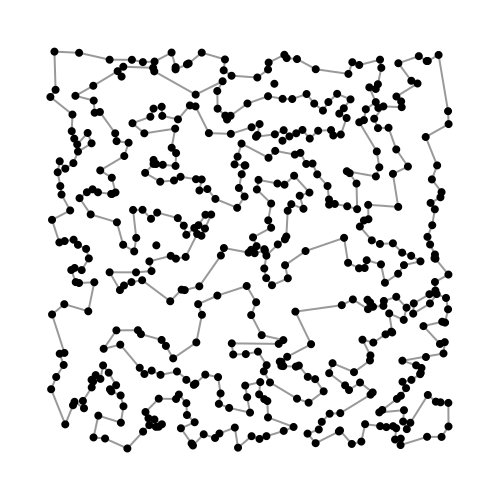

In [5]:
@png drawBoth(I,best) 500 500

## Busca Tabu

Estratégia: declarar arestas tabu. Para isso vamos usar um vetor `tabu` onde tabu[a] para aresta é a iteração até a aresta é tabu (i.e. não podes ser removido nem inserido na solução).  

In [6]:
# export

function is_tabu(s, tabu, i, j)
    a = (s.π[j], s.π[j + 1])
    tabu[a[1], a[2]] >= i
end

function make_tabu(s, tabu, i, τ, j)
    a = (s.π[j], s.π[j + 1])
    tabu[a[1], a[2]] = tabu[a[2], a[1]] = i + τ
end

function bt(I, s, τ)
    tabu = zeros(Int, I.n, I.n)
    i = 1
    ii = 1
    best = copy(s)
    while i - ii < 50
        rb = 0
        Δb = Inf
        for r = 1:twoex_size(I.n)
            m = twoex_unrank(I.n, r)
            Δ = delta_2ex(I, s, m)
            if ( is_tabu(s, tabu, i, m[1]) || is_tabu(s, tabu, i, m[2]) ) && s.v + Δ >= best.v
                continue
            end
            if Δ < Δb
                rb = r
                Δb = Δ
            end
        end
        if rb == 0
            continue ## no move
        end
        m = twoex_unrank(I.n, rb)
        move_2ex(s, m)
        make_tabu(s, tabu, i, τ, m[1])
        make_tabu(s, tabu, i, τ, m[2])
        
        if s.v < best.v
            best = copy(s)
            ii = i
            printfmtln("* {} {:.3f} {:.3f}", i, s.v, best.v)
        else
            printfmtln("  {} {:.3f} {:.3f}", i, s.v, best.v)
        end
        i += 1
    end
    best
end

bt (generic function with 1 method)

In [7]:
best = bt(I, copy(vmp(I)), 3)

* 1 20.685 20.685
* 2 20.542 20.542
* 3 19.826 19.826
* 4 19.684 19.684
* 5 19.568 19.568
* 6 19.457 19.457
* 7 19.362 19.362
* 8 19.230 19.230
* 9 19.141 19.141
* 10 19.056 19.056
* 11 18.978 18.978
* 12 18.918 18.918
* 13 18.859 18.859
* 14 18.803 18.803
* 15 18.754 18.754
* 16 18.707 18.707
* 17 18.664 18.664
* 18 18.624 18.624
* 19 18.586 18.586
* 20 18.548 18.548
* 21 18.513 18.513
* 22 18.479 18.479
* 23 18.447 18.447
* 24 18.415 18.415
* 25 18.384 18.384
* 26 18.353 18.353
* 27 18.324 18.324
* 28 18.267 18.267
* 29 18.239 18.239
* 30 18.213 18.213
* 31 18.182 18.182
* 32 18.157 18.157
* 33 18.106 18.106
* 34 18.042 18.042
* 35 18.003 18.003
* 36 17.978 17.978
* 37 17.958 17.958
* 38 17.937 17.937
* 39 17.917 17.917
* 40 17.900 17.900
* 41 17.886 17.886
* 42 17.871 17.871
* 43 17.852 17.852
* 44 17.838 17.838
* 45 17.825 17.825
* 46 17.810 17.810
* 47 17.797 17.797
* 48 17.785 17.785
* 49 17.774 17.774
* 50 17.763 17.763
* 51 17.752 17.752
* 52 17.741 17.741
* 53 17.732 17.732
* 

Solution([1, 434, 322, 40, 293, 379, 155, 265, 406, 330  …  358, 186, 347, 401, 230, 246, 271, 109, 92, 1], 17.50083940793679)